# Moving Formation Example

This example combines a formation goal in positions with a
consensus goal in velocities. As such, the coordination sheaf
is the constant sheaf $\underline{\R}^4$ on the three vertex path graph.
This encodes a leader-follower topology with the middle agent
in the path acting as the leader. The leader’s objective is
to track a constant rightward velocity vector and minimize
its control actuation while the followers’ objectives are to
simply minimize control actuation. The edge potential functions
are of the form $U_e(y)=(1/2)\|y-b_e\|_2^2$ where the velocity
coordinates of each be are 0 encoding consensus in velocity while
the position coordinates are chosen to achieve a fixed displacement
between the leader and its followers. The results of this
controller run for 160 iterations are shown below.

In [1]:
using Test
using AlgebraicOptimization
using LinearAlgebra
using BlockArrays
using Plots
include("../../../examples/paper-examples/PaperPlotting.jl")
using .PaperPlotting

Set up each agent's dynamics: $x(t+1) = Ax(t) + Bu(t)$

In [2]:
dt = 0.1 # Discretization step size
A = [1 dt 0 0; 0 1 0 0; 0 0 1 dt; 0 0 0 1]
B = [0 0; dt 0; 0 0; 0 dt]
C = [1 0 0 0; 0 0 1 0]
system = DiscreteLinearSystem(A, B, C)

DiscreteLinearSystem([1.0 0.1 0.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 1.0 0.1; 0.0 0.0 0.0 1.0], [0.0 0.0; 0.1 0.0; 0.0 0.0; 0.0 0.1], [1 0 0 0; 0 0 1 0])

Initialize the weight matrices such that the objective only concerns velocities

In [3]:
Q_leader = [0 0 0 0; 0 50 0 0; 0 0 0 0; 0 0 0 50]
Q_follower = zeros(4, 4)
R = I(2)

2×2 LinearAlgebra.Diagonal{Bool, Vector{Bool}}:
 1  ⋅
 ⋅  1

Define the parameters for the MPC

In [4]:
N = 10
control_bounds = [-2.0, 2.0]
params1 = MPCParams(Q_leader, R, system, control_bounds, N, [0.0, 3.0, 0.0, 0.0]) # track this velocity
params2 = params3 = MPCParams(Q_follower, R, system, control_bounds, N)

MPCParams([0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0], Bool[1 0; 0 1], DiscreteLinearSystem([1.0 0.1 0.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 1.0 0.1; 0.0 0.0 0.0 1.0], [0.0 0.0; 0.1 0.0; 0.0 0.0; 0.0 0.1], [1 0 0 0; 0 0 1 0]), [-2.0, 2.0], 10, [0.0, 0.0, 0.0, 0.0])

Define the constant sheaf

In [5]:
c = CellularSheaf([4, 4, 4], [4, 4])
set_edge_maps!(c, 1, 2, 1, I(4), I(4))
set_edge_maps!(c, 1, 3, 2, I(4), I(4))

4×4 LinearAlgebra.Diagonal{Int64, Vector{Int64}}:
 -1   ⋅   ⋅   ⋅
  ⋅  -1   ⋅   ⋅
  ⋅   ⋅  -1   ⋅
  ⋅   ⋅   ⋅  -1

Set up solver to perform MPC and solve the optimization problem with ADMM

In [6]:
x_init = BlockArray(5 * rand(-1.0:0.1:1.0, 12), c.vertex_stalks)
b = [5, 0, 5, 0, -5, 0, 5, 0] # Desired pairwise distance
prob = MultiAgentMPCProblem([params1, params2, params3], c, x_init, b)
alg = ADMM(2.0, 10)
num_iters = 160

160

Run solver on MPC

In [7]:
trajectory, controls = do_mpc!(prob, alg, num_iters)

(Any[[-1.5, -5.0, 4.5, -1.0, -1.0, -4.0, -1.0, -4.5, -4.5, 4.0, -1.5, 3.5], [-2.0, -4.799999998001304, 4.4, -0.7999999980443742, -1.4, -4.110520465317854, -1.45, -4.299999998040427, -4.1, 3.8047380103146575, -1.15, 3.2999999980524413], [-2.4799999998001305, -4.599999996002647, 4.320000000195563, -0.5999999961258118, -1.8110520465317852, -4.197077164131415, -1.8799999998040426, -4.099999996080738, -3.7195261989685338, 3.6047380088238, -0.8200000001947558, 3.099999996071617], [-2.939999999400395, -4.39999999400403, 4.2600000005829814, -0.39999999434310085, -2.2307597629449267, -4.261232724170978, -2.2899999994121165, -3.8999999940953853, -3.3590523980861535, 3.4047380074530103, -0.5100000005875941, 2.8999999941251957], [-3.3799999988007983, -4.199999992005457, 4.220000001148671, -0.21359343680603815, -2.6568830353620245, -4.304335047364997, -2.679999998821655, -3.6999999921360107, -3.0185785973408525, 3.2047380058784256, -0.2200000011750745, 2.699999992179761], [-3.799999998001344, -3.99

Plot results with triangles

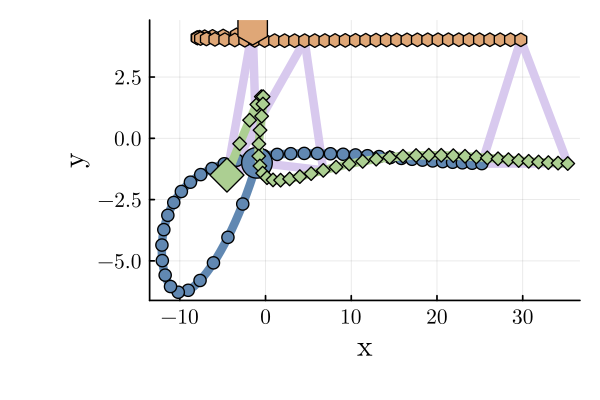

In [8]:
PaperPlotting.plot_trajectories(trajectory, C, false, true)